In [124]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
maxn= 1180
maxcol = 56

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,8), padding='Same',strides=1
                 ,kernel_initializer='he_normal'
                 ,activation='relu', input_shape=(maxn,maxcol,1,)))
model.add(Conv2D(filters=32, kernel_size=(4,8), padding='Same', strides=1
                 ,kernel_initializer='he_normal'
                 ,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (4, 8),kernel_initializer='he_normal', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 1180, 56, 32)      1056      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1180, 56, 32)      32800     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 590, 28, 32)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 590, 28, 32)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 587, 21, 16)       16400     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 293, 10, 16)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 293, 10, 16)       0         
__________

In [73]:
from keras import backend as K

def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

In [74]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 3  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [126]:
class_weights = {0: 3.,
                1: 6.,
                2: 1.,
                3: 3.0,
                4: 4.0,
                5: 2.0}
import numpy as np
path = '/Volumes/Storage/0.SAGAbackup/ARData/'

ytest=np.load(path+'ytest_rm_outlier.npy')
ytrain=np.load(path+'ytrain_rm_outlier_upsample.npy')
xtest=np.load(path+'xtest_rm_outlier.npy')
xtrain=np.load(path+'xtrain_rm_outlier_upsample.npy')
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=['accuracy',
                    single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5)])
hist = model.fit(xtrain,ytrain,batch_size=40,epochs=11,validation_split=0.1)

Train on 5693 samples, validate on 633 samples
Epoch 1/11
5693/5693 [==============================] - 2027s 356ms/step - loss: 0.1851 - acc: 0.9273 - prec: 0.9156 - recall: 0.5276 - prec_1: 0.7396 - recall_1: 0.5484 - prec_2: 0.6875 - recall_2: 0.5088 - prec_3: 0.5034 - recall_3: 0.5871 - prec_4: 0.3010 - recall_4: 0.6707 - prec_5: 0.2720 - recall_5: 0.6913 - val_loss: 0.0020 - val_acc: 1.0000 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00 - val_prec_1: 0.5577 - val_recall_1: 0.1595 - val_prec_2: 0.6452 - val_recall_2: 0.2837 - val_prec_3: 0.4032 - val_recall_3: 0.7472 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.4586 - val_recall_5: 0.6209
Epoch 2/11
5693/5693 [==============================] - 2029s 356ms/step - loss: 0.0100 - acc: 0.9969 - prec: 0.9920 - recall: 0.7206 - prec_1: 0.9373 - recall_1: 0.7019 - prec_2: 0.8435 - recall_2: 0.6101 - prec_3: 0.6592 - recall_3: 0.7333 - prec_4: 0.4715 - recall_4: 0.8588 - prec_5: 0.3690 - recall_5: 0.8946 - val_loss: 

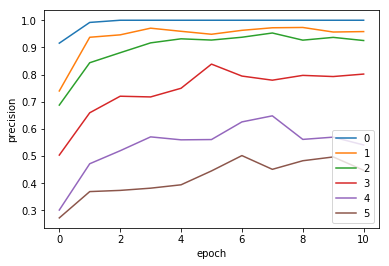

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['prec'], label='0')
plt.plot(hist.history['prec_1'], label='1')
plt.plot(hist.history['prec_2'], label='2')
plt.plot(hist.history['prec_3'], label='3')
plt.plot(hist.history['prec_4'], label='4')
plt.plot(hist.history['prec_5'], label='5')

plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.show()

In [128]:
score=model.evaluate(xtest,ytest)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 10s 108ms/step
Test loss: 1.03726038781
Test accuracy: 0.89893612329


In [67]:
model.save(path+'alienrescue_keras_model_auc9065.h5')

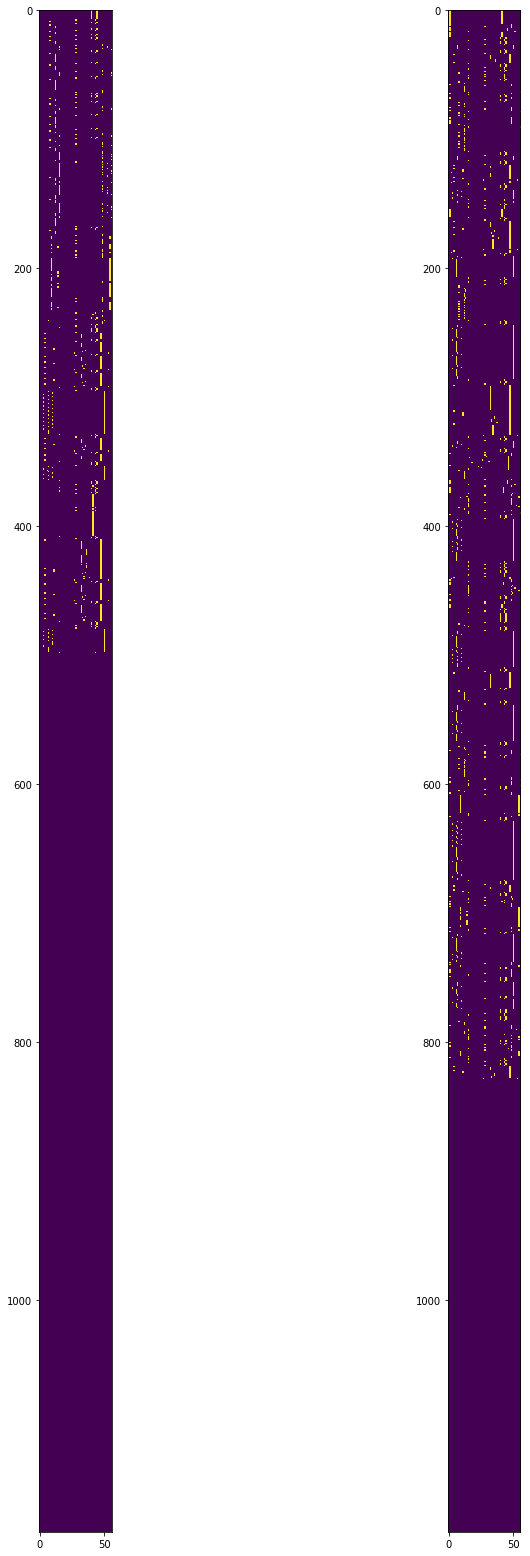

In [123]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 28))
showx = xtest[3,:,:].reshape(maxn, maxcol)
#plt.imshow(showx, cmap='Greys', interpolation='nearest')
plt.imshow(showx, interpolation="nearest")
showx2 = xtrain[6,:,:].reshape(maxn, maxcol)
#plt.imshow(showx, cmap='Greys', interpolation='nearest')

ax = fig.add_subplot(1, 10, 1)
plt.imshow(showx2, interpolation="nearest")

In [159]:
x1 = xtest[[7]]

y1= model.predict(x1)
y1

array([[  3.92019750e-08,   2.14749457e-06,   1.10405374e-04,
          4.26260012e-05,   1.11925136e-03,   4.58333052e-05]], dtype=float32)

In [160]:
ytest[[7]]

array([[0, 0, 0, 0, 0, 0]])

In [161]:
preds = (model.predict((xtest[7]).reshape(1,1180,56,1)) >= 0.33).astype(int)
preds
from sklearn.metrics import accuracy_score
accuracy_score(ytest[[7]], preds)

1.0

In [117]:
yt[[6,7,8,9       ]]

array([[0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])